# 图片增广

AlexNet当年能取得巨大的成功，其中图片增广功不可没。图片增广通过一系列的随机变化生成大量“新”的样本，从而减低过拟合的可能。现在在深度卷积神经网络训练中，图片增广是必不可少的一部分。

## 常用增广方法

我们首先读取一张$400\times 500$的图片作为样例

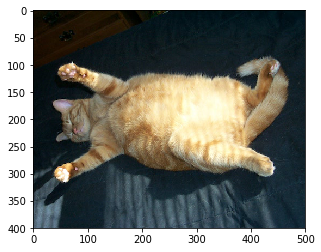

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mxnet import image

img = image.imdecode(open('../img/cat1.jpg', 'rb').read())
plt.imshow(img.asnumpy())

接下来我们定义一个辅助函数，给定输入图片`img`的增广方法`aug`，它会运行多次并画出结果。

In [2]:
from mxnet import nd
import sys
sys.path.append('..')
import utils

def apply(img, aug, n=3):
    # 转成float，一是因为aug需要float类型数据来方便做变化。
    # 二是这里会有一次copy操作，因为有些aug直接通过改写输入
    #（而不是新建输出）获取性能的提升
    X = [aug(img.astype('float32')) for _ in range(n*n)]
    # 有些aug不保证输入是合法值，所以做一次clip
    # 显示浮点图片时imshow要求输入在[0,1]之间
    Y = nd.stack(*X).clip(0,255)/255
    utils.show_images(Y, n, n, figsize=(8,8))

### 变形

水平方向翻转图片是最早也是最广泛使用的一种增广。

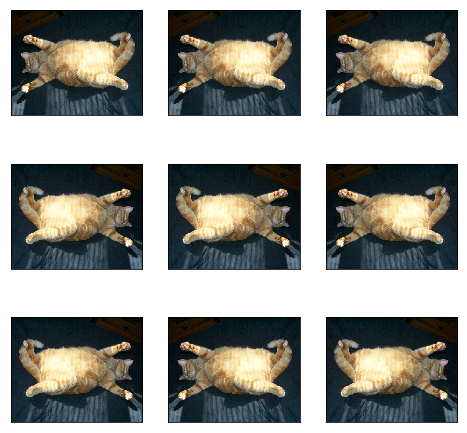

In [3]:
# 以.5的概率做翻转
aug = image.HorizontalFlipAug(.5)
apply(img, aug)

样例图片里我们关心的猫在图片正中间，但一般情况下可能不是这样。前面我们提到池化层能弱化卷积层对目标位置的敏感度，但也不能完全解决这个问题。一个常用增广方法是随机的截取其中的一块。

注意到随机截取一般会缩小输入的形状。如果原始输入图片过小，导致没有太多空间进行随机裁剪，通常做法是先将其放大的足够大的尺寸。所以如果你的原始图片足够大，建议不要事先将它们裁到网络需要的大小。

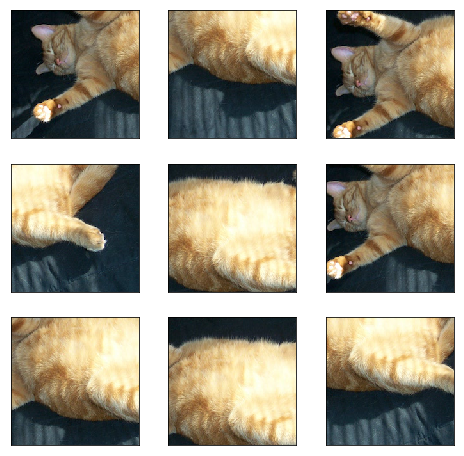

In [4]:
# 随机裁剪一个块 200 x 200 的区域
aug = image.RandomCropAug([200,200])
apply(img, aug)

我们也可以随机裁剪一块随机大小的区域

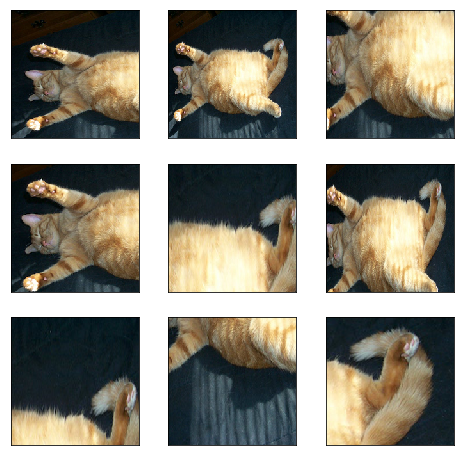

In [5]:
# 随机裁剪，要求保留至少0.1的区域，随机长宽比在.5和2之间。
# 最后将结果resize到200x200
aug = image.RandomSizedCropAug((200,200), .1, (.5,2))
apply(img, aug)

### 颜色变化

形状变化外的一个另一大类是变化颜色。

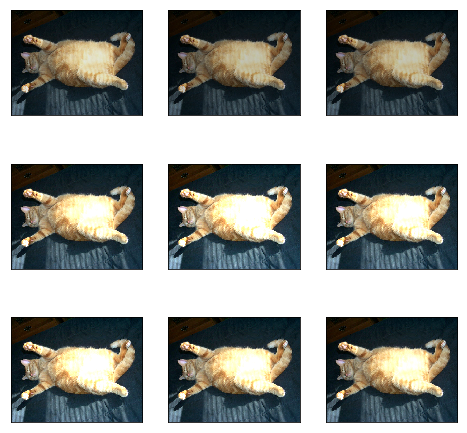

In [6]:
# 随机将亮度增加或者减小在0-50%间的一个量
aug = image.BrightnessJitterAug(.5)
apply(img, aug)

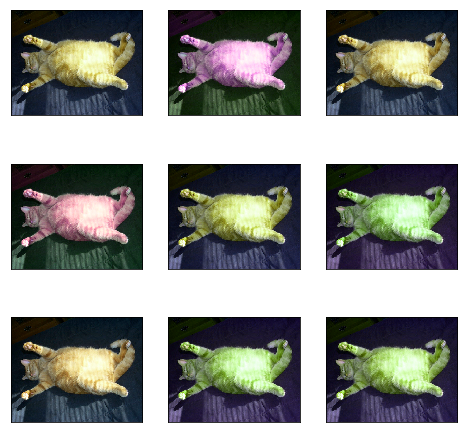

In [7]:
# 随机色调变化
aug = image.HueJitterAug(.5)
apply(img, aug)

## 如何使用

通常使用时我们会将数个增广方法一起使用。注意到图片增广通常只是针对训练数据，对于测试数据则用得较小。后者常用的是做5次随机剪裁，然后讲5张图片的预测结果做均值。

下面我们使用CIFAR10来演示图片增广对训练的影响。我们这里不使用前面一直用的FashionMNIST，这是因为这个数据的图片基本已经对齐好了，而且是黑白图片，所以不管是变形还是变色增广效果都不会明显。

### 数据读取

我们首先定义一个辅助函数可以对图片按顺序应用数个增广：

In [8]:
def apply_aug_list(img, augs):
    for f in augs:
        img = f(img)
    return img

对于训练图片我们随机水平翻转和剪裁。对于测试图片仅仅就是中心剪裁。CIFAR10图片尺寸是$32\times 32\times 3$，我们剪裁成$28\times 28\times 3$.

In [9]:
train_augs = [
    image.HorizontalFlipAug(.5),
    image.RandomCropAug((28,28))
]

test_augs = [
    image.CenterCropAug((28,28))
]

然后定义数据读取，这里跟前面的FashionMNIST类似，但在`transform`中加入了图片增广：

In [10]:
from mxnet import gluon
from mxnet import nd
import sys
sys.path.append('..')
import utils

def get_transform(augs):
    def transform(data, label):
        # data: sample x height x width x channel
        # label: sample
        data = data.astype('float32')
        if augs is not None:
            # apply to each sample one-by-one and then stack
            data = nd.stack(*[
                apply_aug_list(d, augs) for d in data])
        data = nd.transpose(data, (0,3,1,2))
        return data, label.astype('float32')
    return transform

def get_data(batch_size, train_augs, test_augs=None):
    cifar10_train = gluon.data.vision.CIFAR10(
        train=True, transform=get_transform(train_augs))
    cifar10_test = gluon.data.vision.CIFAR10(
        train=False, transform=get_transform(test_augs))
    train_data = utils.DataLoader(
        cifar10_train, batch_size, shuffle=True)
    test_data = utils.DataLoader(
        cifar10_test, batch_size, shuffle=False)
    return (train_data, test_data)

画出前几张看看

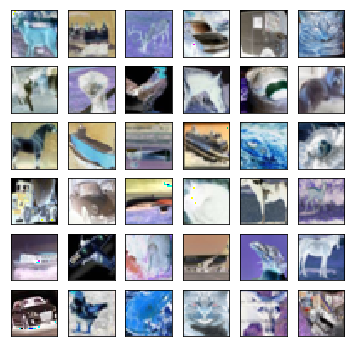

In [11]:
train_data, _ = get_data(36, train_augs)
for imgs, _ in train_data:
    break
utils.show_images(imgs.transpose((0,2,3,1)), 6, 6)

In [12]:
imgs.shape

(36, 3, 28, 28)

## 训练

我们使用[ResNet 18](../chapter_convolutional-neural-networks/resnet-gluon.md)训练。并且训练代码整理成一个函数使得可以重读调用：

In [13]:
from mxnet import init

def train(train_augs, test_augs, learning_rate=.1):
    batch_size = 128
    num_epochs = 10
    ctx = utils.try_all_gpus()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()    
    train_data, test_data = get_data(
        batch_size, train_augs, test_augs)
    net = utils.resnet18(10) 
    net.initialize(ctx=ctx, init=init.Xavier())
    net.hybridize()
    trainer = gluon.Trainer(net.collect_params(),
                            'sgd', {'learning_rate': learning_rate})
    utils.train(
        train_data, test_data, net, loss, trainer, ctx, num_epochs)

使用增广：

In [14]:
train(train_augs, test_augs)

Start training on  [gpu(0), gpu(1)]


Epoch 0. Loss: 1.493, Train acc 0.47, Test acc 0.50, Time 19.1 sec


Epoch 1. Loss: 1.076, Train acc 0.62, Test acc 0.65, Time 18.4 sec


Epoch 2. Loss: 0.902, Train acc 0.68, Test acc 0.65, Time 18.5 sec


Epoch 3. Loss: 0.787, Train acc 0.72, Test acc 0.72, Time 18.2 sec


Epoch 4. Loss: 0.701, Train acc 0.75, Test acc 0.67, Time 18.4 sec


Epoch 5. Loss: 0.642, Train acc 0.77, Test acc 0.76, Time 18.5 sec


Epoch 6. Loss: 0.592, Train acc 0.79, Test acc 0.77, Time 18.3 sec


Epoch 7. Loss: 0.552, Train acc 0.81, Test acc 0.79, Time 18.5 sec


Epoch 8. Loss: 0.517, Train acc 0.82, Test acc 0.79, Time 18.5 sec


Epoch 9. Loss: 0.489, Train acc 0.83, Test acc 0.80, Time 18.3 sec


不使用增广：

In [15]:
train(test_augs, test_augs)

Start training on  [gpu(0), gpu(1)]


Epoch 0. Loss: 1.436, Train acc 0.49, Test acc 0.57, Time 16.7 sec


Epoch 1. Loss: 0.974, Train acc 0.66, Test acc 0.64, Time 16.5 sec


Epoch 2. Loss: 0.753, Train acc 0.74, Test acc 0.67, Time 16.4 sec


Epoch 3. Loss: 0.596, Train acc 0.79, Test acc 0.72, Time 16.5 sec


Epoch 4. Loss: 0.456, Train acc 0.84, Test acc 0.72, Time 16.7 sec


Epoch 5. Loss: 0.351, Train acc 0.88, Test acc 0.74, Time 16.4 sec


Epoch 6. Loss: 0.256, Train acc 0.91, Test acc 0.73, Time 16.6 sec


Epoch 7. Loss: 0.185, Train acc 0.94, Test acc 0.73, Time 16.6 sec


Epoch 8. Loss: 0.137, Train acc 0.95, Test acc 0.74, Time 16.4 sec


Epoch 9. Loss: 0.105, Train acc 0.97, Test acc 0.75, Time 16.7 sec


可以看到使用增广后，训练精度提升更慢，但测试精度比不使用更好。

## 总结

图片增广可以有效避免过拟合。

## 练习

尝试换不同的增广方法试试。


**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/1666)